# Sentiment Analysis of Yelp Reviews (Exploratory Data Analysis)
---

## Contents

* [Introduction](#Introduction)  
* [Review Metrics](#Review_Metrics)
* [Removing Stop Words & Punctuations](#Removing_Stop_Words_Punctuations)
* [Other Review Filtering Methods](#Other_Rev)
* [Word Clouds](#Word_Clouds)
* [Stemming and Lemmatization](#Stem_and_Lem)
* [Positive Opinion Lexicon](#Positive_Op)
* [Word Count Matrix](#WCM)
* [Polarity and Subjectivity](#Pols)
* [Polarity and Positive Word Percentage](#PolPos)
* [Conclusion](#Conclusion)

---

## Introduction

Now that we've gotten all our data we're going to take a closer look and see if we can find a trend or pattern that might be helpful when designing our model. We're also going to begin applying some natural langauge processing techniques like stemming, lemmetization and stop word removals so that we can begin to analyze what these reviews are really trying to say

---

### Objectives

* Explore the data and visualize any patterns or new findings

---

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from sklearn.feature_extraction.text import CountVectorizer

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer

from wordcloud import WordCloud

import textblob
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
yelp_data_final = pd.read_csv('./data/yelp_data_final.csv')

yelp_data_final.head()

,alias,name,rating,price,city,zip_code,address,review
0,morris-park-bake-shop-bronx,['Morris Park Bake Shop'],[4.5],['$$'],['Bronx'],[10462.],['1007 Morris Park Ave'],'Morris Park Bake Shop has become my go to spo...
1,morris-park-bake-shop-bronx,['Morris Park Bake Shop'],[4.5],['$$'],['Bronx'],[10462.],['1007 Morris Park Ave'],'I thought the cookies and biscotti were pret...
2,morris-park-bake-shop-bronx,['Morris Park Bake Shop'],[4.5],['$$'],['Bronx'],[10462.],['1007 Morris Park Ave'],'Guys.... so Im a big time biscotti connoisse...
3,morris-park-bake-shop-bronx,['Morris Park Bake Shop'],[4.5],['$$'],['Bronx'],[10462.],['1007 Morris Park Ave'],'I had a craving for a special type of cake w...
4,morris-park-bake-shop-bronx,['Morris Park Bake Shop'],[4.5],['$$'],['Bronx'],[10462.],['1007 Morris Park Ave'],'The chocolate cups are amazing! Have been ea...


### Data Cleaning

In [3]:
# Create a cleaning function
def clean(review):
    review = review.replace('[', '')
    review = review.replace(']', '')
    review = review.replace('\'', '')
    review = review.replace('\'', '')
    review = review.replace('"', '')

    return review  

In [4]:
# Ensure dtype of review column are str
yelp_data_final['review'] = yelp_data_final['review'].astype(str)

In [5]:
yelp_data_final['name'] = yelp_data_final['name'].apply(lambda x: clean(x))
yelp_data_final['rating'] = yelp_data_final['rating'].apply(lambda x: clean(x))
yelp_data_final['price'] = yelp_data_final['price'].apply(lambda x: clean(x))
yelp_data_final['city'] = yelp_data_final['city'].apply(lambda x: clean(x))
yelp_data_final['zip_code'] = yelp_data_final['zip_code'].apply(lambda x: clean(x))
yelp_data_final['address'] = yelp_data_final['address'].apply(lambda x: clean(x))
yelp_data_final['review'] = yelp_data_final['review'].apply(lambda x: clean(x))

In [6]:
# remove . in zip_code
yelp_data_final['zip_code'] = yelp_data_final['zip_code'].apply(lambda x: x.replace('.', ''))

In [7]:
yelp_data_final.head()

,alias,name,rating,price,city,zip_code,address,review
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,Morris Park Bake Shop has become my go to spot...
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,I thought the cookies and biscotti were prett...
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,Guys.... so Im a big time biscotti connoisseu...
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,I had a craving for a special type of cake wi...
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,The chocolate cups are amazing! Have been eat...


In [8]:
yelp_data_final['rating'].unique()

array(['4.5', '3.', '3.5', '4.', '3. 3.', '2.5', '', '2.', '4. 4.', '5.',
       '1.', '3.5 3.5', '1.5 1.5 1.5 1.5 1.5 1.5', '3. 3. 3.',
       '2.5 2.5 2.5 2.5 2.5 2.5'], dtype=object)

---

Look's like there are some weird entries under the `rating` column. Let's clean it up and convert the datatype to float.

---

In [9]:
def clean_rating(rating):
    if not rating:
        return 0.0
    elif len(rating) <= 3:
        return float(rating)
    else:
        return float(rating[:3])
    
yelp_data_final['rating'] = yelp_data_final['rating'].apply(lambda rating: clean_rating(rating))

In [10]:
yelp_data_final['rating'].unique()

array([4.5, 3. , 3.5, 4. , 2.5, 0. , 2. , 5. , 1. , 1.5])

In [11]:
yelp_data_final['rating'].dtype

dtype('float64')

## Review Metrics <a id='Review_Metrics'></a>

The first metric we're going to look at is the word count for each review.

---

In [12]:
yelp_data_final['word_count'] = yelp_data_final['review'].apply(lambda r: len(r.split()))
yelp_data_final

,alias,name,rating,price,city,zip_code,address,review,word_count
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,Morris Park Bake Shop has become my go to spot...,49
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,I thought the cookies and biscotti were prett...,122
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,Guys.... so Im a big time biscotti connoisseu...,169
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,I had a craving for a special type of cake wi...,59
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,The chocolate cups are amazing! Have been eat...,16
...,...,...,...,...,...,...,...,...,...
14737,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,I am unsure why it is called Turkeys Nest bec...,46
14738,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,This is the favorite haunt of one of my best ...,59
14739,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,Impressed with this bar as one should for how...,44
14740,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,If there ever was a dive bar...When you walk ...,101


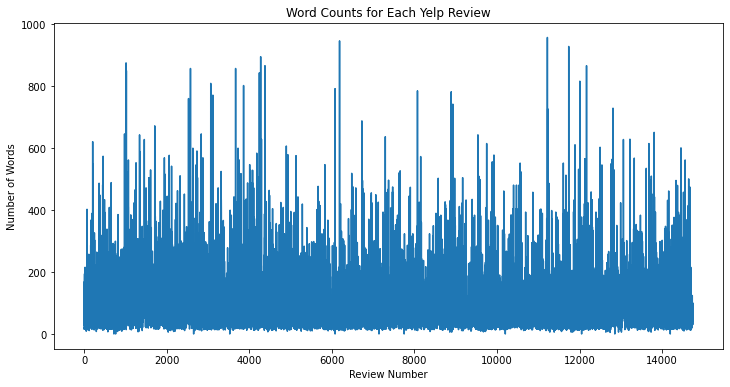

In [13]:
plt.figure(figsize=(12, 6))
yelp_data_final['word_count'].plot()
plt.title('Word Counts for Each Yelp Review')

plt.xlabel('Review Number')
plt.ylabel('Number of Words')

plt.show()

---

Great! It seems like there are no glaring outliers with unusually large number of words. The word count are rather evenly distributed between 200-1000 words.

---

## Removing Stop Words & Punctuations <a id='Removing_Stop_Words_Punctuations'></a>

Stop words like *'the', 'a', 'for'*, or *'so'* don't really have much meaning for sentiment analysis. Removing them is an important step to improve efficiency and make the overall meaning of each review easier to understand with less filler. We will also be removing punctuations.

The code cell below is an example:

---

In [14]:
sentence = 'This is a sample sentence, showing off the stop words filtration.'

stop_words = set(stopwords.words('english'))
sentence_token = word_tokenize(sentence.lower())

filtered_sentence = [word for word in sentence_token if word.isalpha() and word not in stop_words]

print(f'Tokenize sentence: {sentence_token}')
print(f'Filtered sentence: {filtered_sentence}')

Tokenize sentence: ['this', 'is', 'a', 'sample', 'sentence', ',', 'showing', 'off', 'the', 'stop', 'words', 'filtration', '.']
Filtered sentence: ['sample', 'sentence', 'showing', 'stop', 'words', 'filtration']


---

Now let's create a function to remove stop words and punctuations in our `review` column. But first, let's convert all reviews to lowercase.

---

In [15]:
yelp_data_final['review'] = yelp_data_final['review'].apply(lambda r: r.lower())

In [16]:
# Create function to remove stop words and punctuations
def remove_stop_words_punctuations(review):
    review_token = word_tokenize(review)
    review_filtered = [word for word in review_token if word.isalpha() and word not in stop_words]
    return review_filtered

In [17]:
yelp_data_final['review_cleaned'] = yelp_data_final['review'].apply(lambda r: remove_stop_words_punctuations(r))
yelp_data_final

,alias,name,rating,price,city,zip_code,address,review,word_count,review_cleaned
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,morris park bake shop has become my go to spot...,49,"[morris, park, bake, shop, become, go, spot, a..."
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i thought the cookies and biscotti were prett...,122,"[thought, cookies, biscotti, pretty, good, def..."
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,guys.... so im a big time biscotti connoisseu...,169,"[guys, im, big, time, biscotti, connoisseur, a..."
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i had a craving for a special type of cake wi...,59,"[craving, special, type, cake, ice, cream, lay..."
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,the chocolate cups are amazing! have been eat...,16,"[chocolate, cups, amazing, eating, years, alwa..."
...,...,...,...,...,...,...,...,...,...,...
14737,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,i am unsure why it is called turkeys nest bec...,46,"[unsure, called, turkeys, nest, turkeys, love,..."
14738,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,this is the favorite haunt of one of my best ...,59,"[favorite, haunt, one, best, friends, heck, id..."
14739,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,impressed with this bar as one should for how...,44,"[impressed, bar, one, long, manages, get, away..."
14740,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,if there ever was a dive bar...when you walk ...,101,"[ever, dive, bar, walk, bar, friends, see, gia..."


In [18]:
yelp_data_final['review_cleaned'] = yelp_data_final['review_cleaned'].apply(lambda r: ' '.join(r))
yelp_data_final

,alias,name,rating,price,city,zip_code,address,review,word_count,review_cleaned
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,morris park bake shop has become my go to spot...,49,morris park bake shop become go spot atmospher...
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i thought the cookies and biscotti were prett...,122,thought cookies biscotti pretty good definitel...
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,guys.... so im a big time biscotti connoisseu...,169,guys im big time biscotti connoisseur always h...
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i had a craving for a special type of cake wi...,59,craving special type cake ice cream layer regu...
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,the chocolate cups are amazing! have been eat...,16,chocolate cups amazing eating years always tas...
...,...,...,...,...,...,...,...,...,...,...
14737,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,i am unsure why it is called turkeys nest bec...,46,unsure called turkeys nest turkeys love slushe...
14738,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,this is the favorite haunt of one of my best ...,59,favorite haunt one best friends heck id say se...
14739,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,impressed with this bar as one should for how...,44,impressed bar one long manages get away styrof...
14740,turkeys-nest-tavern-brooklyn,Turkeys Nest Tavern,4.0,$,Brooklyn,11211,94 Bedford Ave,if there ever was a dive bar...when you walk ...,101,ever dive bar walk bar friends see giant styro...


## Other Review Filtering Methods <a id='Other_Rev'></a>

Removing stop words is good first step for removing words with no meaning, but lets take a look at all our text and see if there are any words that are frequently repeated.

---

In [19]:
# 20 most common words
pd.Series(''.join(yelp_data_final['review_cleaned']).split()).value_counts()[:20]

food          8451
good          7312
place         7155
great         5240
like          5128
service       4645
one           4281
get           4041
time          3960
would         3440
go            3367
back          3301
really        3283
also          3247
us            3087
restaurant    3049
bar           2958
ordered       2907
got           2799
dont          2762
dtype: int64

## Word Clouds <a id='Word_Clouds'></a>

Now that we have removed the stop words, we can generate a word cloud and we'll be sure that there won't be any filler word present - this will make the more frequently used words that have meaning stand out more as opposed to seeing only stop words

---

In [20]:
def get_all_text(location):
    all_words = ''
    reviews = yelp_data_final[yelp_data_final['name'] == location]['review_cleaned']
    
    for review in reviews:
        all_words += review
    return all_words

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.show()

---

Let's use **Morris Park Bake Shop** as an example for our word cloud.

---

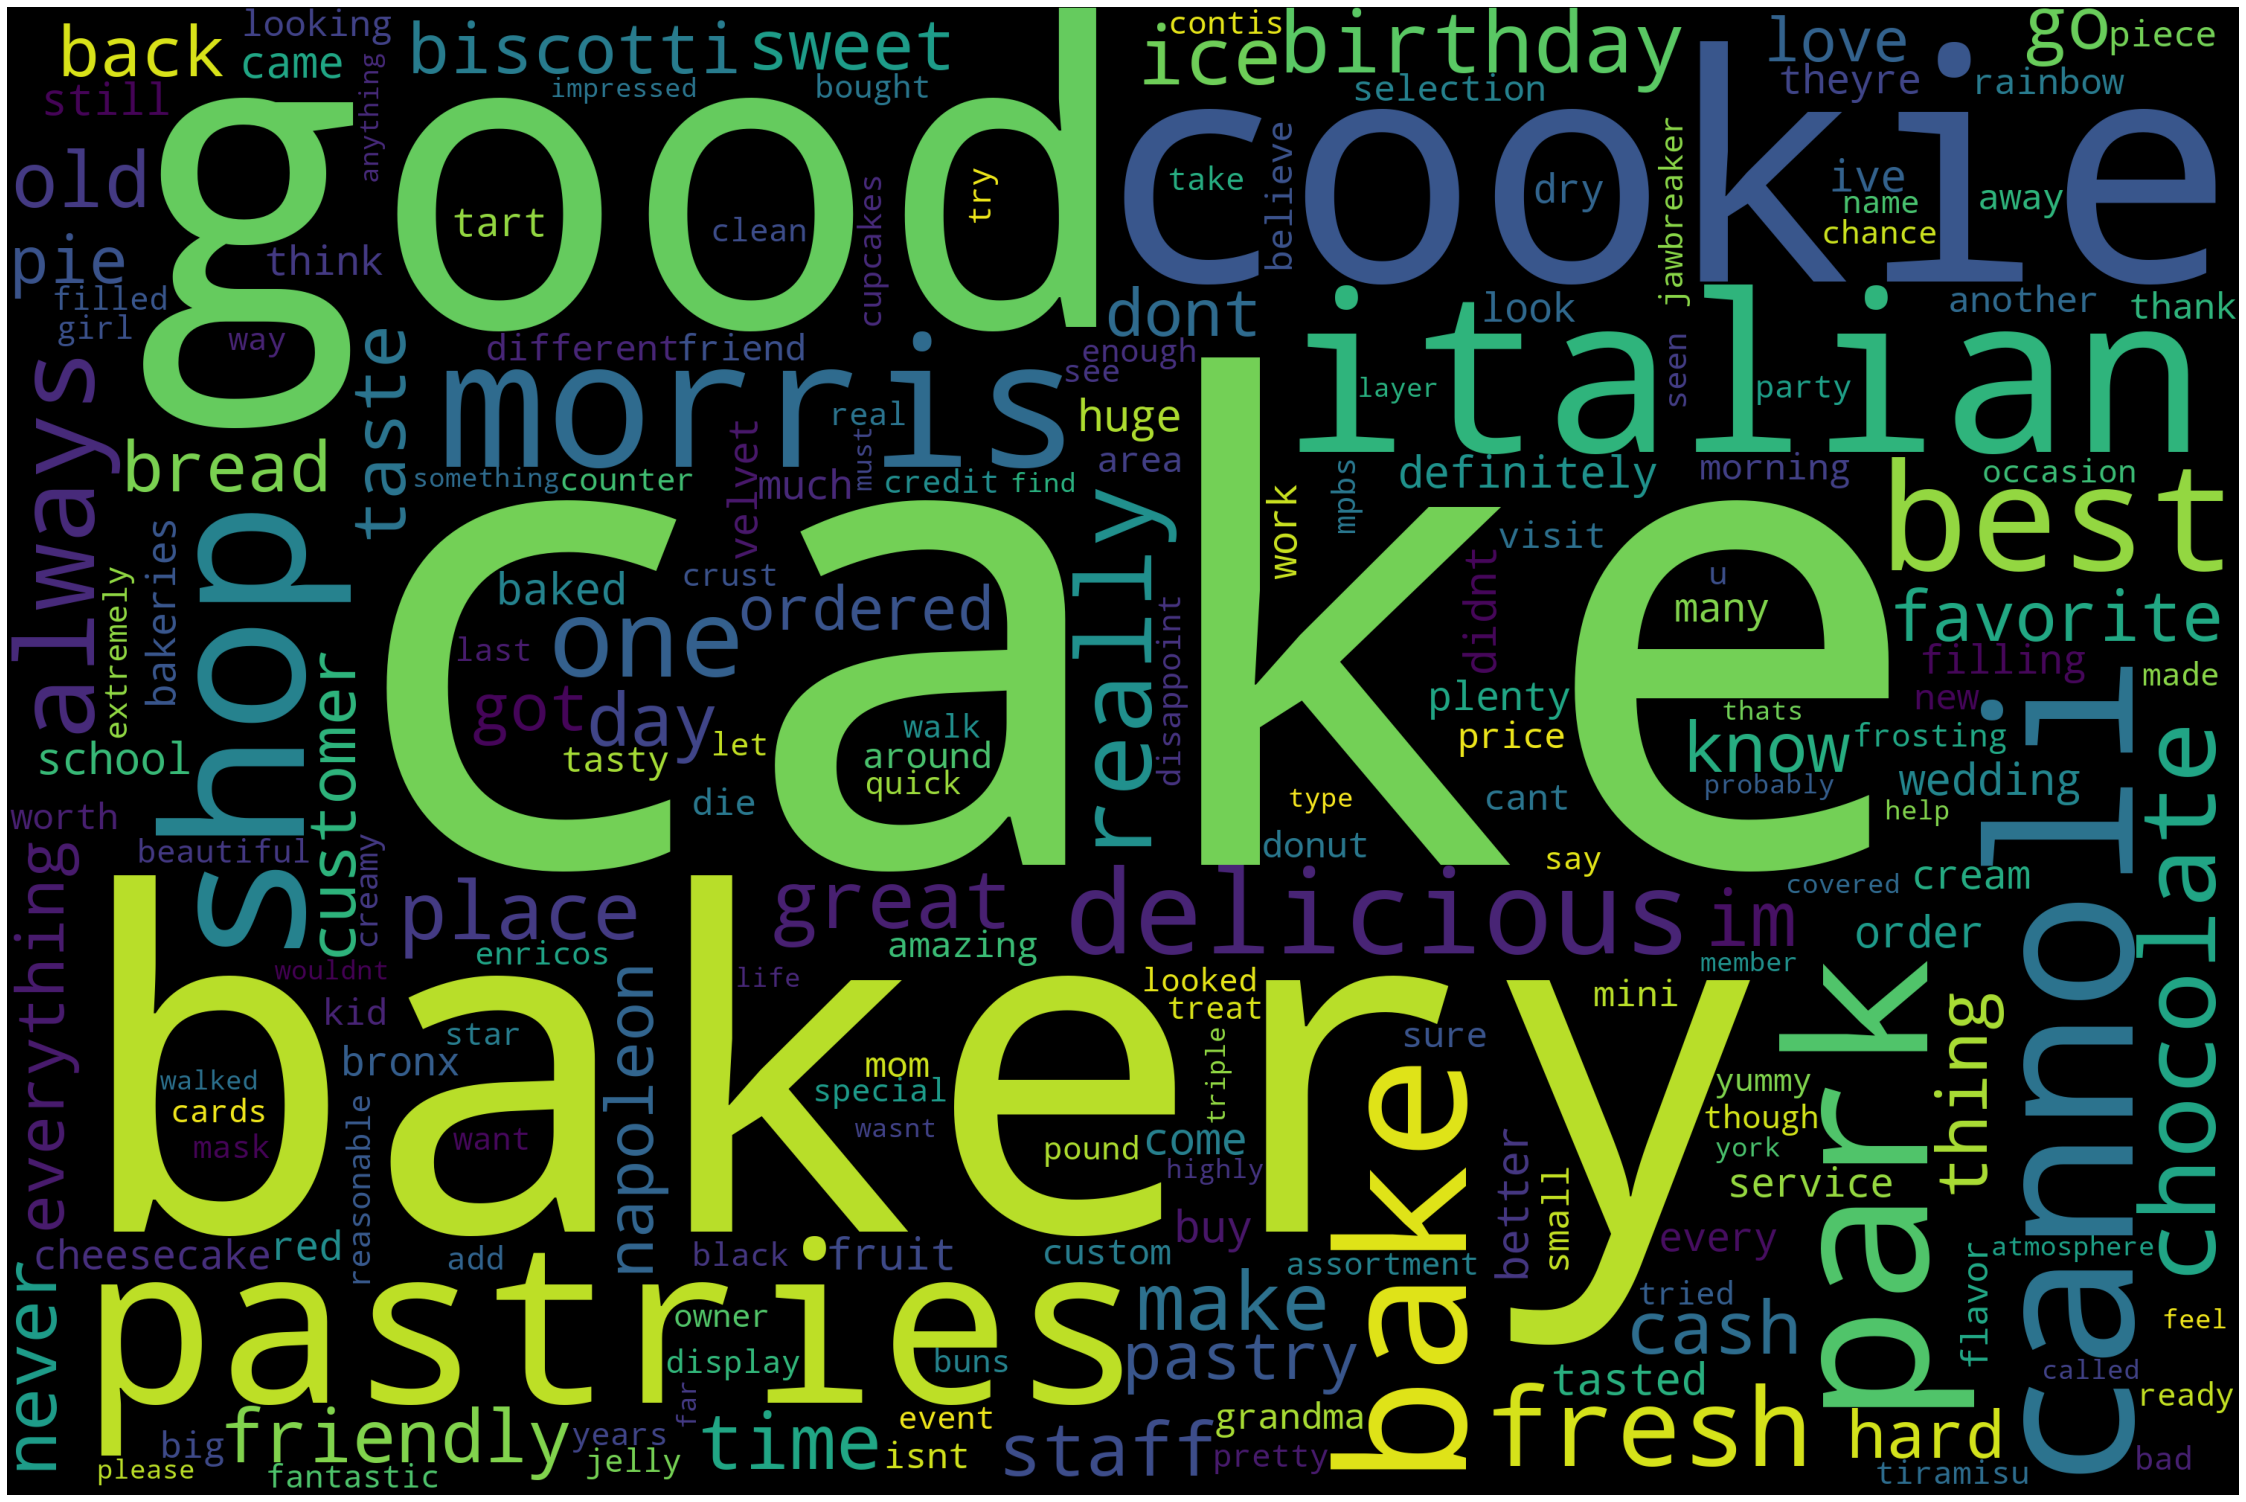

In [21]:
text = get_all_text('Morris Park Bake Shop')

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(text)

plot_cloud(wordcloud)

---

At first glance, the sentiment looks pretty positive!

---

## Stemming and Lemmatization <a id='Stem_and_Lem'></a>

Stemming is an important part of Natural Language Processing. Basically, it is a technique to remove all the suffixes from each word variety and leaves the root word. For example:

* **Flying** becomes **fly** 
* **Waited** becomes **wait**
* **Study** becomes **studi**

This makes the reviews have less unique words which will help when we're counting the frequency of words to determine sentiments.

There are many methods of stemming, but the method I believe makes the most sense for this analysis is the Snowball Stemmer, which is an improved version of the popular Porter Stemmer.

---

Lemmatization makes sure that each word is consistently formatted. For example:

* Study<u>**ing**</u>, stud<u>**ies**</u> -> study
* Troubl<u>**ing**</u>, trouble<u>**d**</u>, trouble<u>**s**</u> -> trouble

Unlike stemming, lemmatization doesn't make the text unreadable.

---

In [22]:
lemmatizer = WordNetLemmatizer()

def lemmatize(review):
    review = review.split()
    
    lemmatized_review = []
    for word in review:
        lemmatized_review.append(lemmatizer.lemmatize(word))
    
    return ' '.join(lemmatized_review)

In [23]:
yelp_data_final['review_lemmatized'] = yelp_data_final['review_cleaned'].apply(lambda x: lemmatize(x))

In [24]:
snowBallStemmer = SnowballStemmer('english')

sentence = yelp_data_final['review_lemmatized'][40]
sentence_token = nltk.word_tokenize(sentence)

stemmed_words = [snowBallStemmer.stem(word) for word in sentence_token]

stemmed = ' '.join(stemmed_words)

# Comparing lemmatization and stemming
print('Lemmatized review: ')
print(sentence)

print('')

print('Stemmed review: ')
print(stemmed)

Lemmatized review: 
awesome bake shop huge variety pastry mini cake ordered napoleon chocolate mouse black white cookie black white cookie bit dry however napoleon chocolate mouse amazing napoleon different one normally bakery usually theyre filled sum kinda bavaraian eclair type cream one filled taste like vanilla pudding great mini cake piece piece put scale price extremely reasonable well

Stemmed review: 
awesom bake shop huge varieti pastri mini cake order napoleon chocol mous black white cooki black white cooki bit dri howev napoleon chocol mous amaz napoleon differ one normal bakeri usual theyr fill sum kinda bavaraian eclair type cream one fill tast like vanilla pud great mini cake piec piec put scale price extrem reason well


---

Let's perform stemming onto the lemmatized reviews.

---

In [25]:
def stemming(review):
    review_token = nltk.word_tokenize(review)
    stemmed = [snowBallStemmer.stem(word) for word in review_token]

    review_stemmed = ' '.join(stemmed)
    return review_stemmed

In [26]:
yelp_data_final['review_stemmed'] = yelp_data_final['review_lemmatized'].apply(lambda r: stemming(r))

In [27]:
yelp_data_final['word_count_stemmed'] = yelp_data_final['review_stemmed'].apply(lambda r: len(r.split()))

In [28]:
yelp_data_final[['word_count', 'word_count_stemmed']]

,word_count,word_count_stemmed
0,49,28
1,122,60
2,169,88
3,59,29
4,16,8
...,...,...
14737,46,23
14738,59,32
14739,44,21
14740,101,45


---

We can see that the word count after removing stop words, punctuations, applying lemmatization and stemming reduced the word counts by as much as half. Let's visualize this on a plot.

---

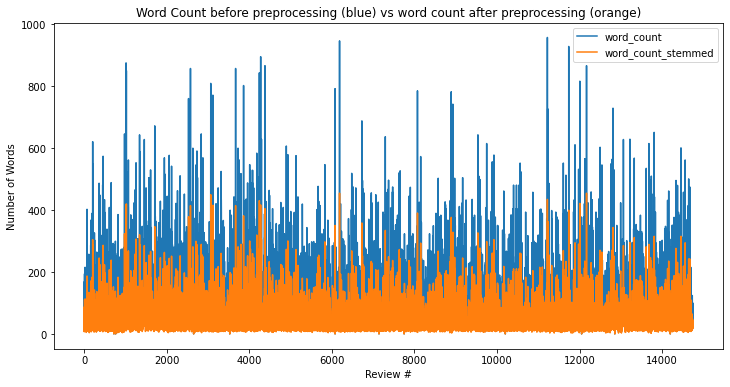

In [29]:
plt.figure(figsize=(12, 6))

yelp_data_final[yelp_data_final['word_count'] < 2000]['word_count'].plot()
yelp_data_final[yelp_data_final['word_count_stemmed'] < 1000]['word_count_stemmed'].plot()

plt.title('Word Count before preprocessing (blue) vs word count after preprocessing (orange)')
plt.xlabel('Review #')
plt.ylabel('Number of Words')

plt.legend()
plt.show()

---

Preprocessing makes a significant impact when it comes to total word count, especially on those longer reviews.

---

## Positive Opinion Lexicon <a id='Positive_Op'></a>

Thanks to the [contribution of a positive opinion lexicon](https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt), we're able to create a positive opinion lexicon based on words commonly associated with positive sentiment. 

This list includes the words you'd expect like *'good', 'great'* and so on, but also common misspellings and phrases on social media. Using this lexicon, we can count how many words within a review are also in the lexicon - this should give us an idea of which reviews are the most positive

---

In [30]:
file = open('./misc/positive_lexicon.txt', 'r')
content = file.read()
pos_lex = [string for string in content.splitlines() if ';' not in string][1:]
pos_lex_stem = [snowBallStemmer.stem(word) for word in pos_lex]

file.close()

In [31]:
# First 20 words
pos_lex_stem[:20]

['a+',
 'abound',
 'abound',
 'abund',
 'abund',
 'access',
 'access',
 'acclaim',
 'acclaim',
 'acclam',
 'accolad',
 'accolad',
 'accommod',
 'accomod',
 'accomplish',
 'accomplish',
 'accomplish',
 'accomplish',
 'accur',
 'accur']

In [32]:
stemmed_token = yelp_data_final['review_stemmed'].apply(lambda r: nltk.word_tokenize(r))
stemmed_token

0        [morri, park, bake, shop, becom, go, spot, atm...
1        [thought, cooki, biscotti, pretti, good, defin...
2        [guy, im, big, time, biscotti, connoisseur, al...
3        [crave, special, type, cake, ice, cream, layer...
4        [chocol, cup, amaz, eat, year, alway, tast, fa...
                               ...                        
14737    [unsur, call, turkey, nest, turkey, love, slus...
14738    [favorit, haunt, one, best, friend, heck, id, ...
14739    [impress, bar, one, long, manag, get, away, st...
14740    [ever, dive, bar, walk, bar, friend, see, gian...
14741    [epitom, dive, bar, love, draft, brooklyn, pro...
Name: review_stemmed, Length: 14742, dtype: object

In [33]:
# Initialize new column to store number of positive word counts
yelp_data_final['positive_word_count'] = 0

In [34]:
for index, stemmed_list in enumerate(stemmed_token):
    count = 0
    for word in stemmed_list:
        if word in pos_lex_stem:
            count += 1
    yelp_data_final.loc[index, 'positive_word_count'] = count
    
yelp_data_final.head()

,alias,name,rating,price,city,zip_code,address,review,word_count,review_cleaned,review_lemmatized,review_stemmed,word_count_stemmed,positive_word_count
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,morris park bake shop has become my go to spot...,49,morris park bake shop become go spot atmospher...,morris park bake shop become go spot atmospher...,morri park bake shop becom go spot atmospher p...,28,6
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i thought the cookies and biscotti were prett...,122,thought cookies biscotti pretty good definitel...,thought cooky biscotti pretty good definitely ...,thought cooki biscotti pretti good definit tas...,60,9
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,guys.... so im a big time biscotti connoisseu...,169,guys im big time biscotti connoisseur always h...,guy im big time biscotti connoisseur always hu...,guy im big time biscotti connoisseur alway hun...,88,13
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i had a craving for a special type of cake wi...,59,craving special type cake ice cream layer regu...,craving special type cake ice cream layer regu...,crave special type cake ice cream layer regula...,29,7
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,the chocolate cups are amazing! have been eat...,16,chocolate cups amazing eating years always tas...,chocolate cup amazing eating year always taste...,chocol cup amaz eat year alway tast fantast,8,2


In [35]:
# Calculate proportion of positive words
yelp_data_final['proportion_positive'] = round(yelp_data_final['positive_word_count'] / yelp_data_final['word_count_stemmed'], 4)

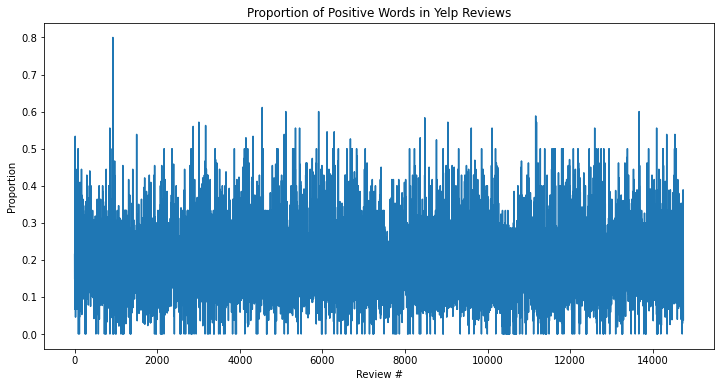

In [36]:
plt.figure(figsize=(12,6))

yelp_data_final['proportion_positive'].plot()

plt.title('Proportion of Positive Words in Yelp Reviews')
plt.xlabel('Review #')
plt.ylabel('Proportion')

plt.show()

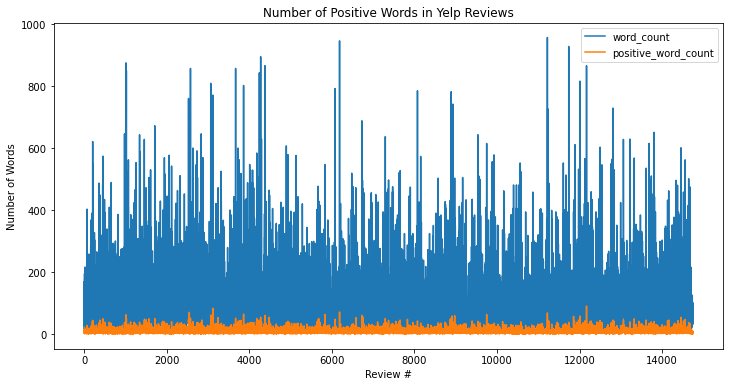

In [37]:
plt.figure(figsize=(12,6))

yelp_data_final[yelp_data_final['word_count'] < 2000]['word_count'].plot()
yelp_data_final[yelp_data_final['positive_word_count'] < 600]['positive_word_count'].plot()

plt.title('Number of Positive Words in Yelp Reviews')
plt.xlabel('Review #')
plt.ylabel('Number of Words')

plt.legend()
plt.show()

## Word Count Matrix <a id='WCM'></a>

The next step is to construct a word matrix. This way, we can get a count of how many times a word appeared throughout the reviews for each location. Once we have a count, we can begin to point out which words are used the most and what the meaning behind these popular words are.

---

In [38]:
def get_all_tokens(location):
    all_tokens = []
    reviews_stemmed = yelp_data_final[yelp_data_final['name'] == location]['review_stemmed']
    
    for review in reviews_stemmed:
        all_tokens.extend(nltk.word_tokenize(review))
    return all_tokens

In [39]:
tokens = get_all_tokens('Morris Park Bake Shop')

# First ten
tokens[:10]

['morri',
 'park',
 'bake',
 'shop',
 'becom',
 'go',
 'spot',
 'atmospher',
 'place',
 'great']

In [40]:
count_vec = CountVectorizer()
X = count_vec.fit_transform(tokens)
word_matrix = pd.DataFrame(X.toarray(), columns=count_vec.get_feature_names())

word_matrix.head()

,abl,absolut,abund,accept,accomod,actual,add,addit,advanc,afford,...,write,wrong,year,yesterday,yet,york,your,youv,yum,yummi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
word_matrix = word_matrix.append(word_matrix.sum(numeric_only=True), ignore_index=True)

# Sort values in descending order based on last row of word matrix
word_matrix = word_matrix.sort_values(by=len(word_matrix)-1, axis=1, ascending=False)

word_matrix.tail()

,cake,bakeri,pastri,good,cooki,bake,italian,best,order,cannoli,...,child,long,locat,lobster,loaf,chin,light,lie,chip,abl
1962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1966,66,32,30,25,24,22,22,20,20,18,...,1,1,1,1,1,1,1,1,1,1


In [42]:
# Get top twenty words that occurred in Morris Park Bake Shop
word_matrix_20 = word_matrix.iloc[-1][:20]
word_matrix_20

cake       66
bakeri     32
pastri     30
good       25
cooki      24
bake       22
italian    22
best       20
order      20
cannoli    18
shop       18
morri      18
park       17
delici     17
tast       16
like       16
friend     14
ice        14
great      14
fresh      13
Name: 1966, dtype: int64

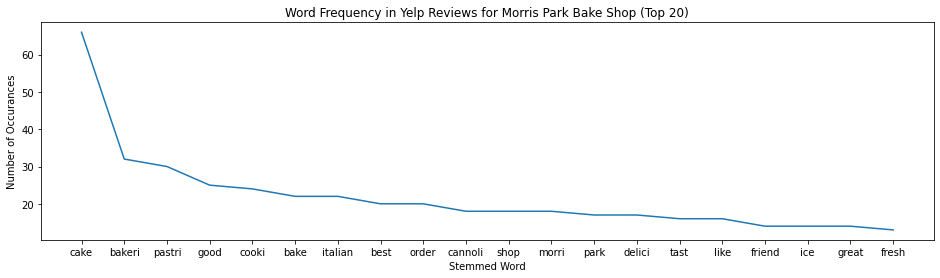

In [43]:
plt.figure(figsize=(16,4))

plt.plot(word_matrix_20)

plt.title('Word Frequency in Yelp Reviews for Morris Park Bake Shop (Top 20)')
plt.xlabel('Stemmed Word')
plt.ylabel('Number of Occurances')

plt.show()

In [44]:
# Let's create a function to accomplish the above example with other restaurants
def get_word_frequency_graph(index):
    
    location = yelp_data_final['name'].unique()[index]
    tokens = get_all_tokens(location)
    X = count_vec.fit_transform(tokens)
    word_matrix = pd.DataFrame(X.toarray(), columns=count_vec.get_feature_names())
    word_matrix = word_matrix.append(word_matrix.sum(numeric_only=True), ignore_index=True)
    word_matrix = word_matrix.sort_values(by=len(word_matrix)-1, axis=1, ascending=False)
    word_matrix_20 = word_matrix.iloc[-1][:20]
    
    plt.figure(figsize=(16,4))

    plt.plot(word_matrix_20)

    plt.title(f'Word Frequency in Yelp Reviews for {location} (Top 20)')
    plt.xlabel('Stemmed Word')
    plt.ylabel('Number of Occurances')

    plt.show()

---

Let's see what the word frequency chart looks like for a place with a lower rating.

---

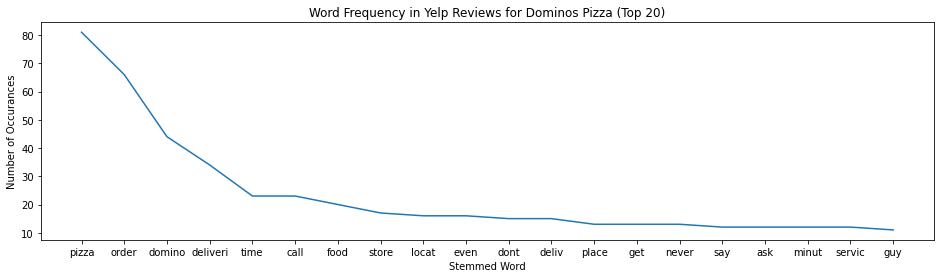

In [45]:
bad_reviews = list(yelp_data_final[yelp_data_final['rating'] <= 2.5]['name'].unique())[5] # Domino's Pizza
resturants = list(yelp_data_final['name'].unique())
bad_index = resturants.index(bad_reviews)

get_word_frequency_graph(bad_index)

---

As you can see, there aren't a lot of positive words, but there aren't many objectively negative words either. Sure you could say that *'dont'* or *'never'* are bad, but what if in context, the reviewer is saying something like 'You don't want to miss this place' or 'I'll never forget the amazing food I had there'. 

We'll have to keep this in mind when creating our model.

---

## Polarity and Subjectivity <a id='Pols'></a>

TextBlob has a very useful library that can determine the Polarity(-1,1) and Subjectivity(0,1) from text. For this project, the polarity is really the only useful one, as it will help us classify the reviews we're working with now and help train for the model, but subjectiveness could be interesting to look into as well

---

In [46]:
yelp_data_final['polarity'] = yelp_data_final['review_lemmatized'].apply(lambda r: TextBlob(r).sentiment[0])
yelp_data_final['subjectivity'] = yelp_data_final['review_lemmatized'].apply(lambda r: TextBlob(r).sentiment[1])

yelp_data_final[['polarity', 'subjectivity']]

,polarity,subjectivity
0,0.338889,0.552778
1,0.314583,0.438194
2,0.238068,0.587311
3,0.314643,0.536044
4,0.500000,0.900000
...,...,...
14737,0.128125,0.675000
14738,0.393750,0.562500
14739,0.458333,0.591667
14740,0.019048,0.486905


---

Let's test with the example of a restaurant with bad reviews like the Domino's we used for an example above. With all these negative reviews it should have a polarity well close to 0.

---

In [47]:
pol = yelp_data_final[yelp_data_final['name'] == bad_reviews]['polarity'].mean()
pol

0.005886484158049976

---

In this case, the average polarity matches up with the overall rating for this restaurant.

---

## Polarity and Positive Word Percentage <a id='PolPos'></a>

Let's see if there is a relationship between the percentage of positive words in a review and its polarity. I'll be doing this by storing the data into three sets:

* **Polarity < 0:** Meaning these reviews should be negative and, therefore have a lower proportion of positive words 
* **Polarity > 0:** Where the proportion of positive words SHOULD go up
* **Polarity = 0:** Where the sentiment should be neutral, so the proportion should be in between the other categories

---

In [48]:
neg_df = yelp_data_final[yelp_data_final['polarity'] < 0].sort_values(by='polarity').reset_index()
pos_df = yelp_data_final[yelp_data_final['polarity'] > 0].sort_values(by='polarity').reset_index()
neu_df = yelp_data_final[yelp_data_final['polarity'] == 0].sort_values(by='polarity').reset_index()


neu_df.index=np.arange(len(neg_df),(len(neg_df)+len(neu_df)))
pos_df.index=np.arange((len(neu_df)+len(neg_df)),(len(neg_df)+len(neu_df)+len(pos_df)))

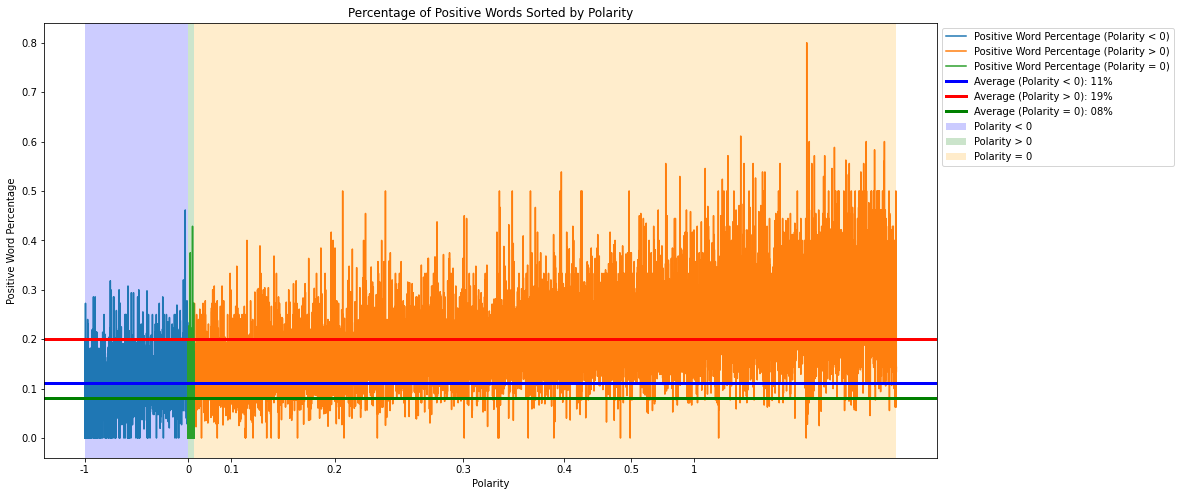

In [49]:
# Set up figure
fig, ax = plt.subplots(figsize=(16,8))

x = yelp_data_final.index

# set x axis for partial plots
x1 = neg_df.index
y1 = neg_df['proportion_positive']
x2 = pos_df.index
y2 = pos_df['proportion_positive']
x3 = neu_df.index
y3 = neu_df['proportion_positive']

# calculate average for each partial
av1 = neg_df['proportion_positive'].mean()
av2 = pos_df['proportion_positive'].mean()
av3 = neu_df['proportion_positive'].mean()

# plot word percentage
plt.plot(x1,y1,label='Positive Word Percentage (Polarity < 0)')
plt.plot(x2,y2,label='Positive Word Percentage (Polarity > 0)')
plt.plot(x3,y3,label='Positive Word Percentage (Polarity = 0)')

# plot area to define polarity zones
plt.axvspan(0, len(neg_df), facecolor='blue', alpha=0.2,label='Polarity < 0')
plt.axvspan(len(neg_df),(len(neg_df)+len(neu_df)), facecolor='green',alpha=0.2,label='Polarity > 0')
plt.axvspan((len(neg_df)+len(neu_df)),(len(neg_df)+len(neu_df)+len(pos_df)), facecolor='orange',alpha=0.2, label='Polarity = 0')

# plot average lines
plt.axhline(y=av1,linewidth=3, color='b',label='Average (Polarity < 0): '+str(av1)[2:4]+'%')
plt.axhline(y=av2,linewidth=3, color='r',label='Average (Polarity > 0): '+str(av2)[2:4]+'%')
plt.axhline(y=av3,linewidth=3, color='g',label='Average (Polarity = 0): '+str(av3)[2:4]+'%')

# label x axis as polarity
labels = ['-1','0','0.1','0.2','0.3','0.4','0.5','1']
ticks = [0,len(neg_df),2655,4539,6869,8704,9924,11065]

ax.set_xticks(ticks)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1, 1))
plt.title('Percentage of Positive Words Sorted by Polarity')
plt.xlabel('Polarity')
plt.ylabel('Positive Word Percentage')
plt.show()

---

As you can see by this plot, there's a gradual increase in 'Positive Words Percentage' As the Polarity goes up - so does the percentage of positive words. This seems like it could be very useful when it comes to classifying reviews with our model later on and it makes absolute intuitive sense.

---

## Conclusion

We now have a much better understanding of our data and have several metrics to use while working with these reviews. We know the total number of words, the number of words after removing stop words, how many of those words are positive words and how we can use that information, along with the polarity values to classify the reviews into positive, negative or neutral sentiments.

Moving forward, it'll be good to determine whether or not we want to make multiple categories, like a five star system or to just stick with positive and negative, if we go with the first option we need to figure our where the cutoff for a 4 star vs a 5 star might be among other things. For now though, on to modeling!

---

In [51]:
yelp_data_final.to_csv('./data/yelp_data_final_2.csv', index=False)